In [12]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import torchvision

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src.datasets import get_dataset, get_dataloader, TSN_Labels
from src.utils import parse_data_cfg, IMG, TSN, FPHA, DATA_DIR
from src.models import get_model

In [8]:
exp_fold = ''
cfgname = 'tsn_fpha_yolov2_bb_lr001_416_batch16'
cfg = parse_data_cfg(WORK_DIR/'data_cfg'/exp_fold/(cfgname + '.cfg'))
cfg['device'] = 0
epoch = 500
exp_dir = cfg["exp_dir"]
data_split = 'train'
data_list = cfg[data_split + '_set']
class_dict = FPHA.get_class_name_dict()

In [3]:
model = get_model(cfg, True, epoch, None, None)

# Train dataloader

In [4]:
input, target = next(iter(model.train_loader))
input = input.permute(0, 2, 3, 1)
print(input.shape)

torch.Size([16, 416, 416, 9])


In [5]:
idx = 10
cur_input = input[idx]
cur_target = target[idx].item()
cur_target = class_dict[cur_target]

img1 = cur_input[:, :, :3]
img2 = cur_input[:, :, 3:6]
img3 = cur_input[:, :, 6:]

img1 = cv2.normalize(np.asarray(img1), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
img2 = cv2.normalize(np.asarray(img2), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
img3 = cv2.normalize(np.asarray(img3), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)

unfold_glasses


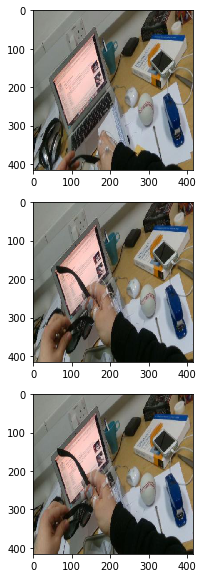

In [7]:
print(cur_target)
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

# Test dataloader

In [9]:
model = get_model(cfg, False, epoch, None, None)

In [13]:
data_set        = data_split + '_set'
dataset_kwargs  = {'split_set': cfg[data_set]}
cfg['aug']      = None
cropping = torchvision.transforms.Compose([
    TSN.GroupOverSample(model.net.input_size, model.net.scale_size)])
pred_tfm = torchvision.transforms.Compose([
    cropping,
    TSN.Stack(roll=False),
    TSN.ToTorchFormatTensor(div=True),
    TSN.GroupNormalize(model.net.input_mean, model.net.input_std)])
pred_dataset = TSN_Labels(cfg, cfg[data_set], pred_tfm,
                             random_shift=True, test_mode=True)
pred_kwargs =  {'batch_size'  :   1,
                'shuffle'     :   False,
                'num_workers' :   int(cfg['num_workers']),
                'pin_memory'  :   True}
data_loader = DataLoader(pred_dataset,
                         sampler=None,
                         **pred_kwargs)


In [14]:
input, target = next(iter(data_loader))
input = input.permute(0, 2, 3, 1)
print(input.shape)

torch.Size([1, 416, 416, 750])


In [17]:
idx = 0
cur_input = input[0]
cur_target = target[0].item()
cur_target = class_dict[cur_target]
print(cur_target)

squeeze_sponge


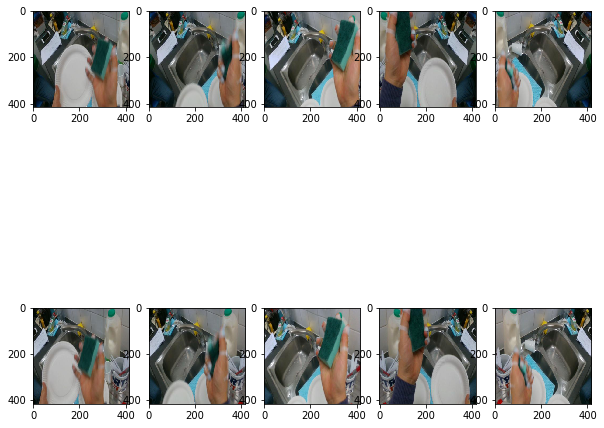

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(10, 10))
idx = 0
for i in range(2):
    for j in range(5):
        img = cur_input[:, :, idx*3:idx*3 + 3]
        img = cv2.normalize(np.asarray(img), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
        ax[i, j].imshow(img)
        idx += 10